## Cats vs Dogs

Проблема заключается в задаче двоичной классификации, требующей предсказания одного значения либо 0, либо 1. Будет использоваться выходной слой с 1 узлом и сигмоидной активацией, а модель будет оптимизирована с использованием двоичной функции кросс-энтропийных потерь.

In [1]:
import pandas as pd
import zipfile
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
os.listdir("data")

['test1.zip', 'train.zip']

In [4]:
zip_files = os.listdir("data")

for zip_file in zip_files:
    with zipfile.ZipFile("data/{}".format(zip_file),"r") as z:
        z.extractall("data/")
        print("{} unzipped".format(zip_file))

test1.zip unzipped
train.zip unzipped


In [5]:
print(os.listdir("data"))

['test1.zip', 'test1', 'train.zip', 'train']


In [6]:
# размер входного изображения сети
IMG_SIZE = (224, 224) 

In [7]:
targets=list()
full_paths=list()

FILE_NAMES_train=os.listdir("data/train")

for file_name in FILE_NAMES_train:
    target=file_name.split(".")[0]#получаем незвание класса dog или cat
    full_path=os.path.join("data/train", file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset_train=pd.DataFrame()
dataset_train['image_path']=full_paths
dataset_train['target']=targets

In [8]:
dataset_train.head()

,image_path,target
0,data/train/cat.1984.jpg,cat
1,data/train/cat.184.jpg,cat
2,data/train/cat.778.jpg,cat
3,data/train/dog.2939.jpg,dog
4,data/train/cat.3538.jpg,cat


In [9]:
target_counts=dataset_train['target'].value_counts()

print("Number of dogs in the dataset: {}".format(target_counts['dog']))
print("Number of cats in the dataset: {}".format(target_counts['cat']))

Number of dogs in the dataset: 12500
Number of cats in the dataset: 12500


**Визуализируем данные**

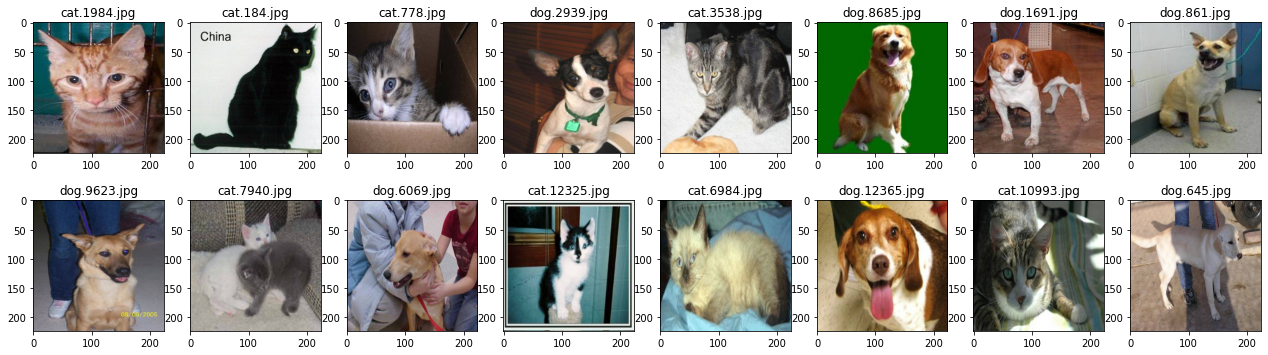

In [10]:
fig = plt.figure(figsize=(22, 6))

for i, path in enumerate(dataset_train['image_path'][:16], 1):
    subplot = fig.add_subplot(2, 8, i)
    subplot.set_title('%s' % path.split('/')[-1])
    
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    
    plt.imshow(img)

**Преобразуем данные**

Используем ImageDataGenerator для предварительной обработки изображений.

**Разделим извесные данные (train) на учебную и тестовую выборки (чтобы обучить модель)**

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset_train, test_size=0.2, random_state=42)

In [12]:
from keras.preprocessing.image import ImageDataGenerator

batch_size=64

train_datagen = ImageDataGenerator(rescale=1.0 / 255.0, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True)


train_generator = train_datagen.flow_from_dataframe(
    train,
    x_col="image_path",
    y_col="target",
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    class_mode="binary",)

Found 20000 validated image filenames belonging to 2 classes.


In [13]:
valid_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

valid_generator = train_datagen.flow_from_dataframe(
    test,
    x_col="image_path",
    y_col="target",
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    class_mode="binary",)

Found 5000 validated image filenames belonging to 2 classes.


**Смотрим как работает генератор**

In [14]:
dataset_train.sample(n=1).reset_index(drop=True)

,image_path,target
0,data/train/cat.9399.jpg,cat


In [15]:
example_df = dataset_train.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df,  
    x_col='image_path',
    y_col='target',
    target_size=(224,224),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


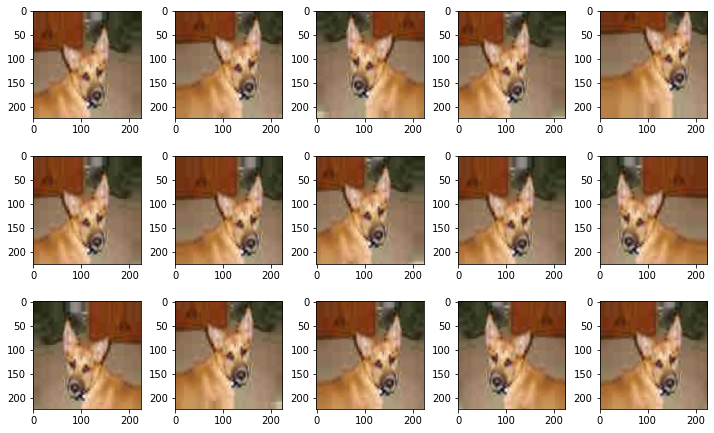

In [16]:
plt.figure(figsize=(10, 10))
for i in range(0, 15):
    plt.subplot(5, 5, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

**Загружаем модель**

In [17]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights='imagenet',#предварительное обучение на ImageNet
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [18]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
base_model.layers[-6].output

<tf.Tensor 'block4_pool/MaxPool:0' shape=(None, 14, 14, 512) dtype=float32>

**Добавляем полносвязный слой**

In [20]:
from tensorflow.keras.layers import Flatten, Dense
import tensorflow as tf

# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.layers[-1].output
x = Flatten()(x)
x = Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')    

In [21]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

Все модели CNN следуют аналогичной архитектуре, как показано на рисунке ниже.


<img src="1.png">

Есть входное изображение, с которым мы работаем. Мы выполняем серию операций свертки + объединения, за которыми следует ряд полностью связанных слоев. Если мы выполняем мультиклассовую классификацию, на выходе получается softmax.

1. Input Layer: Данные входного изображения. Преобразует изображение в одномерный массив. Например, размер изображения 64x64 = 4096, тогда он будет преобразован в массив (4096,1).

2. Conv Layer: Основным строительным блоком CNN является сверточный слой. Свертка - это математическая операция для объединения двух наборов информации. В нашем случае свертка применяется к входным данным с использованием фильтра свертки для создания карты признаков.

3. Stride: Определяет, насколько мы перемещаем фильтр свертки на каждом шаге. По умолчанию значение равно 1.

4. Padding: Размер изображения, после свертки, меньше чем входное. Если хотим сохранить ту же размерность, можем использовать заполнение, чтобы окружить изображение (до преобразования) нулями.

5. Pooling Layer: После операции свертки обычно выполняем объединение для уменьшения размерности. Это позволяет уменьшить количество параметров, что сокращает время обучения и помогает бороться с переобучением.

6. Fully Connected Layer: Соединяет сеть от одного уровня к другому. После слоев свертки + пула добавляем пару полностью связанных слоев, чтобы завершить архитектуру CNN.

7. Conv2D: Этот метод создает сверточный слой. Первый параметр - количество фильтров, а второй - размер фильтра. Например, в первом сверточном слое создаем 32 фильтра размером 3x3. Используем нелинейность relu как активацию. Также включаем отступы. В Keras есть два варианта заполнения: same или valid. same означает, что мы добавляем нули по краю изображения, а valid означает отсутствие заполнения. По умолчанию шаг равен 1 для сверточных слоев, поэтому не меняем это значение.

8. MaxPooling2D: создает слой maxpooling, единственный аргумент - размер окна. Используем окно 2x2, как самое распространенное. По умолчанию длина шага равна размеру окна, который в нашем случае равен 2, поэтому мы не меняем это значение.

9. Flatten: После слоев свертки + объединения мы сглаживаем их выходные данные для подачи в полностью связанные слои.

10. Dropout: Самый популярный метод регуляризации для глубоких нейронных сетей. Dropout используется для предотвращения переобучения, и идея очень проста. Во время обучения на каждой итерации нейрон временно «отбрасывается» или отключается с вероятностью p. Это означает, что все входы и выходы этого нейрона будут отключены на текущей итерации.

11. Output Layer: Это слой прогнозируемых значений

Архитектура предполагает наложение сверточных слоев с небольшими фильтрами 3 × 3, за которыми следует объединяющий слой. Вместе эти уровни образуют блок, и эти блоки могут повторяться, где количество фильтров в каждом блоке увеличивается с глубиной сети, например 32, 64, 128, 256 для первых четырех блоков модели. Отступы используются в сверточных слоях, чтобы гарантировать, что формы высоты и ширины выходных карт объектов соответствуют входным.


In [22]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11672910534457981373
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 286193323920627939
physical_device_desc: "device: XLA_CPU device"
]


In [23]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
train.shape[0]

20000

In [26]:
history=model.fit(train_generator,
                                epochs=10,
                                validation_data=valid_generator,
                                validation_steps=test.shape[0]//batch_size,
                                steps_per_epoch=train.shape[0]//batch_size
                                )

Epoch 1/10
312/312 [==============================] - 7396s 24s/step - loss: 0.3226 - accuracy: 0.8655 - val_loss: 0.2672 - val_accuracy: 0.8998
Epoch 2/10
312/312 [==============================] - 7038s 23s/step - loss: 0.2476 - accuracy: 0.9071 - val_loss: 0.2510 - val_accuracy: 0.9091
Epoch 3/10
312/312 [==============================] - 7026s 23s/step - loss: 0.2382 - accuracy: 0.9144 - val_loss: 0.2883 - val_accuracy: 0.8896
Epoch 4/10
312/312 [==============================] - 7013s 22s/step - loss: 0.2370 - accuracy: 0.9160 - val_loss: 0.2774 - val_accuracy: 0.8970
Epoch 5/10
312/312 [==============================] - 7014s 22s/step - loss: 0.2355 - accuracy: 0.9186 - val_loss: 0.2514 - val_accuracy: 0.9099
Epoch 6/10
312/312 [==============================] - 7025s 23s/step - loss: 0.2282 - accuracy: 0.9216 - val_loss: 0.2886 - val_accuracy: 0.8980
Epoch 7/10
312/312 [==============================] - 7018s 22s/step - loss: 0.2374 - accuracy: 0.9181 - val_loss: 0.2562 - val_ac

In [52]:
print("Train Accuracy:{:.3f}".format(model.history.history['accuracy'][-1]))
print("Test Accuracy:{:.3f}".format(history.history['val_accuracy'][-1]))

Train Accuracy:0.920
Test Accuracy:0.916


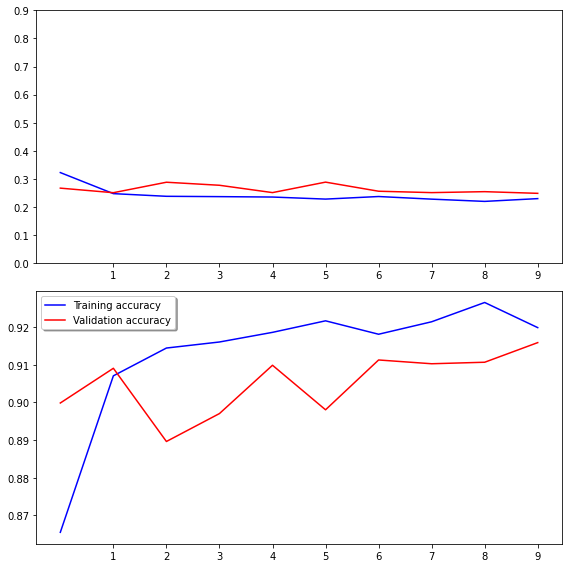

In [59]:
import numpy as np

epochs = 10

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))


ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)

plt.tight_layout()
plt.show()

**Сохраним модель**

In [39]:
model.save('model.h5')

In [18]:
from tensorflow.keras.models import load_model

model = load_model('model.h5', compile=True)

**Загружаем картинки для проверки обученной модели**

In [60]:
test_filenames = os.listdir("data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})

In [61]:
test_df

,filename
0,8034.jpg
1,9448.jpg
2,998.jpg
3,6618.jpg
4,5320.jpg
...,...
12495,5345.jpg
12496,943.jpg
12497,10735.jpg
12498,10300.jpg


In [76]:
test_gen=ImageDataGenerator(rescale=1/255)

test_generator=test_gen.flow_from_dataframe(
    test_df,
    'data/test1/',
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(224,224),
    batch_size=64,
    shuffle=False)

Found 12500 validated image filenames.


**Рапознаем картинки**

In [78]:
predict = model.predict(test_generator, steps=np.ceil(test_df.shape[0]/batch_size))

In [119]:
threshold = 0.6
test_df['category'] = np.where(predict > threshold, 1,0)

Для категориальной классификации прогноз будет с вероятностью каждой категории. Итак, мы выберем категорию с наибольшей вероятностью с numpy medium max.

In [98]:
predict[:5]

array([[3.9676726e-03],
       [8.1799370e-01],
       [1.0000000e+00],
       [1.6861139e-06],
       [9.9982309e-01]], dtype=float32)

In [120]:
test_df['category']

0        0
1        1
2        1
3        0
4        1
        ..
12495    0
12496    0
12497    0
12498    1
12499    0
Name: category, Length: 12500, dtype: int64

Мы преобразуем категорию прогноза обратно в наши классы-генераторы с помощью train_generator.class_indices. Это классы, которые сопоставляют генератор изображений при преобразовании данных в компьютерное зрение.

In [121]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

<AxesSubplot:>

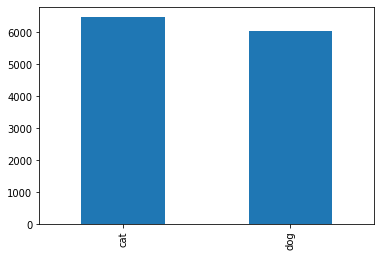

In [122]:
test_df['category'].value_counts().plot.bar()

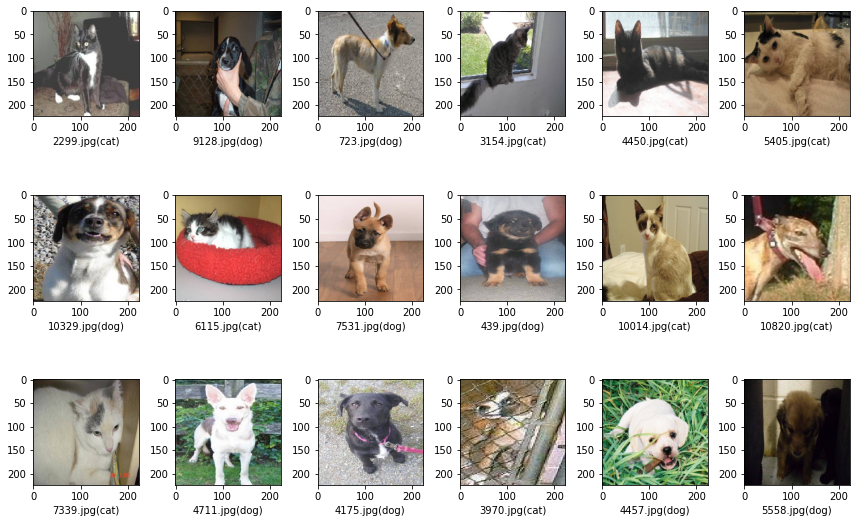

In [123]:
from keras.preprocessing import image

sample_test = test_df.sample(n=18).reset_index()
sample_test.head()
plt.figure(figsize=(12, 8))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = image.load_img('data/test1/' + filename, target_size=(224, 224))
    plt.subplot(3, 6, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()